## We solve the MHD toy model with PINN

### The evolution equations are:

$$
\partial_t B^i = \nabla_j (v^j B^i - v^i B^j) \;\;\;\; \nabla_i B^i = 0
$$

The vector field $v^i$ is given. 

And we impose Dirichlet boundary conditions.

The initial data is: 

\begin{align*}
B_1 &= \partial_y \phi \\
B_2 &= -\partial_x \phi
\end{align*}
with (here we use xmin=0, xmax = 1, same for y)

$$
\phi(x,y) = (x*(x-1)*y*(y-1))^2
$$

The velocity field is time-independent and given by:

\begin{align*}
v1(t,x,y) &= \sin(\pi*x)*\cos(\pi*y) \\
v2(t,x,y) &= \cos(\pi*x)*\sin(\pi*y) \\
\end{align*}



In [2]:
#import Pkg
#Pkg.add(url="https://github.com/psy3nt1st/Optim.jl.git")
using Optim
#using NeuralPDE
#using Optimization
using OptimizationOptimJL
using Roots
using LineSearches
using ModelingToolkit, IntervalSets 
using IntervalSets
using Plots, Printf
using Lux, LuxCUDA, ComponentArrays, Random
using JLD2, LinearAlgebra 
using Revise
using Distributions
using Zygote
using StatsBase
using NBInclude

const gpud = gpu_device()


(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [3]:
# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------

config = Dict(
    :N_input => 3,          # [t , x, y]
    :N_neurons => 64,
    :N_layers => 4,
    :N_output => 2, 
    :N_points => 60_000,     # puntos de colisión (x,t)
    :BCS_points => 10_000,
    :N_points0 => 10_000, # puntos para las condiciones iniciales
    :Minibatch => 500,
    :xmin => 0.0,
    :xmax => 1.0,           # = L dominio espacial
    :ymin => 0.0,
    :ymax => 1.0,           # = L dominio espacial
    :tmin => 0.0,           # t_min
    :tmax => 4.0,           # t_max
    #:optimizer => BFGS(),
    :optimizer => SSBroyden(),
    :maxiters => 6_000,
    :N_rounds => 20,               # nº de rondas RAD
    :iters_per_round => 500,       # iteraciones BFGS por ronda
    #k1, k2 = 1.0, 1          # hiperparámetros RAD
    :N_test => 120_000,             # candidatos por ronda, mayor que N_points
    # for the initial data
    :A => 1.0,
    :p => 2,
    :c => 1.0,
    # for discretizations
    :dx => [0.1, 0.1, 0.1]
)


@show config

config = Dict{Symbol, Any}(:N_input => 3, :N_test => 120000, :iters_per_round => 500, :N_points => 60000, :N_neurons => 64, :A => 1.0, :N_output => 2, :ymax => 1.0, :BCS_points => 10000, :ymin => 0.0, :tmax => 4.0, :maxiters => 6000, :p => 2, :c => 1.0, :N_layers => 4, :N_points0 => 10000, :xmin => 0.0, :xmax => 1.0, :tmin => 0.0, :N_rounds => 20, :Minibatch => 500, :optimizer => SSBroyden{InitialStatic{Float64}, HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}(InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
  cache: Nothing nothing
  check_flatness: Bool false
, nothing, nothing, Flat()), :dx => [0.1, 0.1, 0.1])


Dict{Symbol, Any} with 23 entries:
  :N_input         => 3
  :N_test          => 120000
  :iters_per_round => 500
  :N_points        => 60000
  :N_neurons       => 64
  :A               => 1.0
  :N_output        => 2
  :ymax            => 1.0
  :BCS_points      => 10000
  :ymin            => 0.0
  :tmax            => 4.0
  :maxiters        => 6000
  :p               => 2
  :c               => 1.0
  :N_layers        => 4
  :N_points0       => 10000
  :xmin            => 0.0
  :xmax            => 1.0
  :tmin            => 0.0
  ⋮                => ⋮

In [4]:
includet("../neural_tools.jl")

### The velocity fields 

The actual computation for the code are done on the function compute_V_and_DV()

In [4]:
#v1(t,x,y) = cos(pi*x)
#v2(t,x,y) = cos(pi*y) # with minus is divergence free

r0 = 0.16
r2(x,y) = (x-0.5)^2 + (y-0.5)^2
v1(t,x,y) = (x-0.5)*r2(x,y)*(r2(x,y) - r0)
v2(t,x,y) = (y-0.5)*r2(x,y)*(r2(x,y) - r0)



v2 (generic function with 1 method)

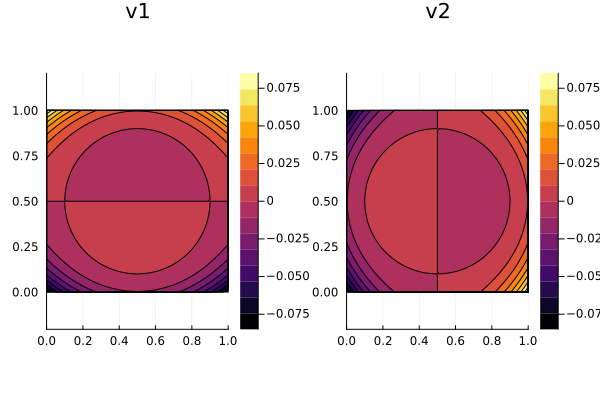

In [5]:
xs = collect(config[:xmin]:0.01:config[:xmax])
ys = collect(config[:ymin]:0.01:config[:ymax])

v1_d = [(x-0.5)*r2(x,y)*(r2(x,y) - r0) for x in xs for y in ys]
v2_d = [(y-0.5)*r2(x,y)*(r2(x,y) - r0) for x in xs for y in ys]
pv1 = plot(ys, xs, v1_d, linetype = :contourf, title = "v1", aspect_ratio = 1)
pv2 = plot(ys, xs, v2_d, linetype = :contourf, title = "v2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))

In [29]:
ts = collect(config[:tmin]:0.01:config[:tmax])
xs = collect(config[:xmin]:0.01:config[:xmax])
ys = collect(config[:ymin]:0.01:config[:ymax])

V1 = [calculate_V_and_DVs(0.0, [x,], [y,])[1] for x in xs, y in ys]

@show typeof(V1) size(V1)
#@show typeof(DxV1) size(DxV1)
#M = reshape(V1, (length(xs), length(ys)))
#plot(ys, xs, M, linetype = :contourf, title = "v1", aspect_ratio = 1)

V1[1,1]
#M

typeof(V1) = Matrix{Vector{Float64}}
size(V1) = (101, 101)


1-element Vector{Float64}:
 -0.08499999999999999

### The initial magnetic fields

The actual computations are done on the function for the boundary (initial) conditions.

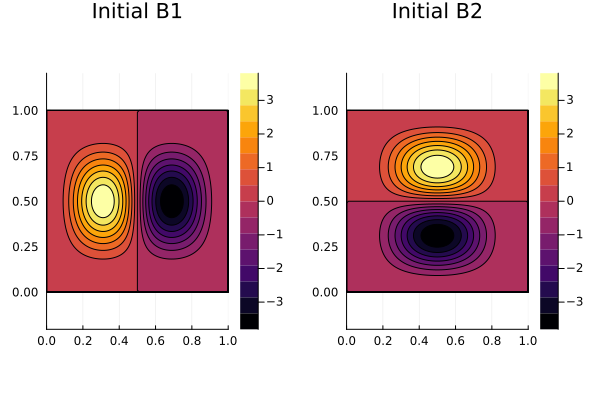

In [6]:
phi(x,y) = (x*(x-1)*y*(y-1))^4*2^(4p)

p=4
B1_d = [ p*y^(p-1)*(y-1)^(p-1)*(2y-1)*x^p*(x-1)^p*2^(4p) for x in xs for y in ys]
B2_d = [ -p*x^(p-1)*(x-1)^(p-1)*(2x-1)*y^p*(y-1)^p*2^(4p) for x in xs for y in ys]
pv1 = plot(xs, ys, B1_d, linetype = :contourf, title = "Initial B1", aspect_ratio = 1)
pv2 = plot(xs, ys, B2_d, linetype = :contourf, title = "Initial B2", aspect_ratio = 1)
plot(pv1, pv2, layout = (1,2))



In [7]:

function B0(x,y,p)
    B1_0 =  p.*y.^(p-1).*(y.-1).^(p-1).*(2y.-1).*x.^p.*(x.-1).^p.*2^(4p)
    B2_0 = -p.*x.^(p-1).*(x.-1).^(p-1).*(2x.-1).*y.^p.*(y.-1).^p.*2^(4p)
    return B1_0, B2_0 
end

B0 (generic function with 1 method)

### The equations

In [8]:

eqs(B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2, V1, V2, DxV1, DxV2, DyV1, DyV2) = [DtB1 - DyV2 .* B1 - V2 .* DyB1 + DyV1 .* B2 + DyB2 .* B1, 
    DtB2 - DxV1 .* B2 - DxB2 .* V1 + DxV2 .* B1 + DxB1 .* V2 , 
    DxB1 + DyB2]


eqs (generic function with 1 method)

### Boundary conditions

Using the constraint the equations are equivalent to:

$$
\partial_t B^i = v^j\partial_j B^i + l.o.t.
$$
Thus, at the boundaries we have to impose boundary conditions (non-incoming in our case) only when
$v^jn_j \geq 0$.

Otherwise we could put periodic boundary conditions by imposing for instance $B^i(t,0,y) = B^i(t,L,y)$


In [9]:
non_incoming = false
periodic = false

#non_incoming = true
#periodic = true
if non_incoming 
bcs(B1, B2, B10, B20, V1, V2) = [B1 - B10,
    B2 - B20,
    (1 - sign(V1[0,:]))*sign(V1[0,:])*B1[0,:],
    (1 + sign(V1[end,:]))*sign(V1[end,:])*B1[end,:],
    (1 - sign(V2[:,0]))*sign(V2[:,0])*B1[:,0],
    (1 + sign(V2[:,end]))*sign(V2[:,end])*B1[:,end],
    (1 - sign(V1[0,:]))*sign(V1[0,:])*B2[0,:],
    (1 + sign(V1[end,:]))*sign(V1[end,:])*B2[end,:],
    (1 - sign(V2[:,0]))*sign(V2[:,0])*B2[:,0],
    (1 + sign(V2[:,end]))*sign(V2[:,end])*B2[:,end]]

elseif periodic

    bcs(B1, B2, B10, B20, V1, V2) = [B1 - B10,
    B2 - B20] # periodicity is hard implemented
    
else
    bcs(B1, B2, B10, B20, V1, V2) = [B1 - B10,
    B2 - B20] # when V is outgoing in all the boundary.
end


bcs (generic function with 1 method)

In [10]:
NN, Θ, st = create_neural_network(config)
input = generate_input_t_x_y(config) # the order is t,x,y.
input0 = generate_input0_xy(config) # the order is t,x,y.
input_total = [input, input0]

@show typeof(input) size(input)
@show typeof(input_total) size(input_total)
@show typeof(Θ) size(Θ)
@show typeof(NN(input[:,:], Θ, st)[1]) size(NN(input[:,:], Θ, st)[1])

#NN(input[:,:], Θ, st)[1][1,:]

typeof(input) = CuArray{Float64, 2, CUDA.DeviceMemory}
size(input) = (3, 6000)
typeof(input_total) = Vector{CuArray{Float64, 2, CUDA.DeviceMemory}}
size(input_total) = (2,)
typeof(Θ) = ComponentVector{Float64, CuArray{Float64, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:256, Axis(weight = ViewAxis(1:192, ShapedAxis((64, 3))), bias = ViewAxis(193:256, Shaped1DAxis((64,))))), layer_2 = ViewAxis(257:4416, Axis(weight = ViewAxis(1:4096, ShapedAxis((64, 64))), bias = ViewAxis(4097:4160, Shaped1DAxis((64,))))), layer_3 = ViewAxis(4417:8576, Axis(weight = ViewAxis(1:4096, ShapedAxis((64, 64))), bias = ViewAxis(4097:4160, Shaped1DAxis((64,))))), layer_4 = ViewAxis(8577:12736, Axis(weight = ViewAxis(1:4096, ShapedAxis((64, 64))), bias = ViewAxis(4097:4160, Shaped1DAxis((64,))))), layer_5 = ViewAxis(12737:16896, Axis(weight = ViewAxis(1:4096, ShapedAxis((64, 64))), bias = ViewAxis(4097:4160, Shaped1DAxis((64,))))), layer_6 = ViewAxis(16897:17026, Axis(weight = ViewAxis(1:128, ShapedA

(2, 6000)

In [11]:
#input_total[1][1:1,:]


In [12]:
#t, x, y = input_total[1][1:1, :], input_total[1][2:2, :], input_total[1][3:3, :]

#B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2 = calculate_fields_and_derivatives_Toy_MHD(t, x, y, NN, Θ, st)

#@show typeof(B1) size(B1)
#@show typeof(DtB1) size(DtB1)
#y

In [25]:
```
Residual at collocation points
``` 

function residual_at_points_Toy_MHD(input_total, NN, Θ, st)
    # residual for the equations
    t, x, y = input_total[1][1:1, :], input_total[1][2:2, :], input_total[1][3:3, :]
    B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2  = calculate_fields_and_derivatives_Toy_MHD(t, x, y, NN, Θ, st)
    V1, V2, DxV1, DxV2, DyV1, DyV2 = calculate_V_and_DVs(t, x, y)
    res_eq = eqs(B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2, V1, V2, DxV1, DxV2, DyV1, DyV2)
    # residual for the initial conditions
    t0, x0, y0 = input_total[2][1:1, :], input_total[2][2:2, :], input_total[2][2:2, :]
    B10, B20 = B0(x0, y0, config[:p])
    #@show typeof(B10) size(B10)
    B1, B2, DtB1, DtB2, DxB1, DxB2, DyB1, DyB2  = calculate_fields_and_derivatives_Toy_MHD(t0, x0, y0, NN, Θ, st)
    #@show typeof(B1) size(B1)
    V1, V2, DxV1, DxV2, DyV1, DyV2 = calculate_V_and_DVs(t0, x0, y0)
    res_bc = bcs(B1, B2, vec(B10), vec(B20), V1, V2)
    #res = vcat(res_eq, res_bc)
    #@show typeof(vec(res_eq[1] |> cpu_device())) size(vec(res_eq[1] |> cpu_device()))
    return vcat(vec(abs.(res_eq[1] |> cpu_device())), vec(abs.(res_eq[2] |> cpu_device())), vec(abs.(res_eq[3] |> cpu_device()))),  vcat(vec(abs.(res_bc[1] |> cpu_device())), vec(abs.(res_bc[2] |> cpu_device()))) # magnitud del residuo en CPU
end


residual_at_points_Toy_MHD (generic function with 1 method)

In [26]:
Eq, BC = residual_at_points_Toy_MHD(input_total, NN, Θ, st)

([0.07572714209759449, 0.0243764261652904, 0.0053765870812242655, 0.0029494301693467166, 0.00804956892919442, 0.012098315731998377, 0.017474937552202946, 0.001224117748332254, 0.001074294318742934, 0.019344520191081127  …  0.01913382112979889, 0.00021834857761859894, 0.0006496235728263855, 0.0031069330871105194, 0.008342715911567211, 0.004793101456016302, 0.0031063351780176163, 0.0037987539544701576, 6.813928484916687e-5, 0.0018648523837327957], [0.0006026606428197745, 0.000489511381339458, 0.00038621576540776026, 0.0005099265849506374, 0.0004944908200288367, 0.002359340763199269, 0.0004313369946316037, 0.00048396044546228367, 0.0011937645872970581, 0.0003750163492555192  …  0.00038969250767340036, 0.00021071680586248753, 0.0006800988887203374, 0.00012279156779038125, 0.0042423199286940015, 0.0014660122389198449, 0.001360989984231481, 0.0006175292057113424, 0.0007946317100387956, 0.004321562250705818])

In [ ]:

# -------------------------------------------------------------------
# Loss function 
# -------------------------------------------------------------------

function loss_function_Toy_MHD(input_total, NN, Θ, st)
    res_eq, res_bcs = residual_at_points_Toy_MHD(input_total, NN, Θ, st)
    #return NaNMath.log10(sum(abs2, res) / length(res))
    #return log10(sum(abs2, res_eq) / length(res_eq) + sum(abs2, res_bcs) / length(res_bcs))
    return sum(abs2, res_eq) / length(res_eq) + sum(abs2, res_bcs) / length(res_bcs)
end


# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    push!(losses, l)
    println("Current loss: ", l)
    return false
end

callback (generic function with 1 method)

In [17]:
#loss_function_Toy_MHD(input, NN, Θ, st)
losses = Float64[]

Float64[]

In [18]:
adaptive = true
adaptive = false

@unpack N_rounds, iters_per_round, N_test, N_points = config
optf   = OptimizationFunction((Θ, input_total) -> loss_function_Toy_MHD(input_total, NN, Θ, st), AutoZygote())

if adaptive 
    
    # Configura las rondas adaptativas (ajusta a tu gusto)
    #nrounds = 20                # nº de rondas RAD
    #iters_per_round = 500       # iteraciones BFGS por ronda
    #k1, k2 = 1.0, 1          # hiperparámetros RAD
    #Ntest = 20_000              # candidatos por ronda

    for r in 1:N_rounds
        @info "RAD round $r / $N_rounds  |  iters=$iters_per_round"
        # Optimiza sobre el conjunto actual de colisión
        #optf   = OptimizationFunction((Θ, input) -> loss_function_Toy_MHD(input, NN, Θ, st), AutoZygote())
        global optprob = OptimizationProblem(optf, Θ, input_total)
        global optresult  = solve(
            optprob,
            config[:optimizer];
            callback = (p, l) -> callback(p, l, losses),
            maxiters = iters_per_round,
        )
        global Θ = optresult.u  # continúa desde el óptimo de la ronda

        # Re-muestrea puntos de colisión ponderando por residuo
        global input = adaptive_rad_toy_MHD(NN, Θ, st, config; Ntest=N_test, Nint=N_points)#, k1=k1, k2=k2)
        global input0 = generate_input0_xy(config) # reset input0
        global input_total = [input, input0]
    end

else
    for r in 1:N_rounds
        @info "Normal training round $r / $N_rounds  |  iters=$iters_per_round"

    #optf = OptimizationFunction((Θ, input) -> loss_function_Toy_MHD(input, NN, Θ, st), AutoZygote())
    global optprob = OptimizationProblem(optf, Θ, input_total)

    global optresult = solve(
        optprob,
        callback = (p, l) -> callback(p, l, losses),
        config[:optimizer],
        maxiters = iters_per_round,
    )
    global Θ = optresult.u  # continúa desde el óptimo de la ronda
    global input = generate_input_t_x_y(config) # reset input
    global input0 = generate_input0_xy(config) # reset input0
    global input_total = [input, input0]
    end
end

# Parámetros optimizados a CPU si procede
res = optresult.u |> cpu_device()


┌ Info: Normal training round 1 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: 0.5139693974541241
Current loss: 0.26809147178359505
Current loss: 0.13970449450402764
Current loss: 0.08007960363765829
Current loss: 0.06117171497236078
Current loss: -0.07401254613459816
Current loss: -0.12466040761414975
Current loss: -0.1494978418033267
Current loss: -0.21349024043683526
Current loss: -0.27809916739788754
Current loss: -0.35282046167500947
Current loss: -0.37581601647088925
Current loss: -0.4237322359402406
Current loss: -0.4520298211271752
Current loss: -0.4810330983317388
Current loss: -0.5059935220570879
Current loss: -0.5296857807908145
Current loss: -0.5548689556919577
Current loss: -0.587804243217916
Current loss: -0.6240451706228879
Current loss: -0.6659579550289929
Current loss: -0.7028395544012449
Current loss: -0.7255880197585705
Current loss: -0.7712467915649918
Current loss: -0.810923010206863
Current loss: -0.8307811403221221
Current loss: -0.8357556026526084
Current loss: -0.8738892454551445
Current loss: -0.9159192140370753
Current los

┌ Info: Normal training round 2 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -3.2920120569376556
Current loss: -3.292276395129723
Current loss: -3.292882892182033
Current loss: -3.293248858354452
Current loss: -3.293782128757258
Current loss: -3.2943625025705314
Current loss: -3.2948232402275632
Current loss: -3.295297255896059
Current loss: -3.2955418127232945
Current loss: -3.2960746580454137
Current loss: -3.2966123813980546
Current loss: -3.297161227438408
Current loss: -3.297626021220717
Current loss: -3.297956036953064
Current loss: -3.298411352033122
Current loss: -3.2987433061836473
Current loss: -3.298905472908135
Current loss: -3.299409059955161
Current loss: -3.299848840842732
Current loss: -3.3004884754077555
Current loss: -3.3009416639234304
Current loss: -3.301593452850618
Current loss: -3.302068885501141
Current loss: -3.302789474346567
Current loss: -3.303743647615661
Current loss: -3.3044461311869666
Current loss: -3.305126254109178
Current loss: -3.3059812167250673
Current loss: -3.306926430315005
Current loss: -3.307963069873965

┌ Info: Normal training round 3 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.682362146495577
Current loss: -2.6986696401434607
Current loss: -2.724362785624196
Current loss: -2.7389543448387315
Current loss: -2.75411137348025
Current loss: -2.7730064618818484
Current loss: -2.7860204693029407
Current loss: -2.7996939922666226
Current loss: -2.815506101065422
Current loss: -2.8307339103390143
Current loss: -2.841423410074777
Current loss: -2.8566456354354295
Current loss: -2.875501482234993
Current loss: -2.884659917467566
Current loss: -2.893700031943682
Current loss: -2.9098654327851956
Current loss: -2.9262839675181285
Current loss: -2.9404174988330913
Current loss: -2.948505127332046
Current loss: -2.9560964110884176
Current loss: -2.9675719156477784
Current loss: -2.982212946945188
Current loss: -2.9922798532807784
Current loss: -3.00274334567338
Current loss: -3.0111917808873865
Current loss: -3.024233544484794
Current loss: -3.0359544889549506
Current loss: -3.050207230041428
Current loss: -3.0641908708817436
Current loss: -3.073804958170

┌ Info: Normal training round 4 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -3.4299101862163868
Current loss: -3.4302037141522272
Current loss: -3.430707850092166
Current loss: -3.4312615711756433
Current loss: -3.4317683455231847
Current loss: -3.4323026744692897
Current loss: -3.4327410701170287
Current loss: -3.4334029697764468
Current loss: -3.4340737567691266
Current loss: -3.434873669389976
Current loss: -3.435530734093979
Current loss: -3.435809695437402
Current loss: -3.4362508939626677
Current loss: -3.4370653917496354
Current loss: -3.437700220968377
Current loss: -3.4384138730751244
Current loss: -3.438958322216201
Current loss: -3.439624104291197
Current loss: -3.4404509900691784
Current loss: -3.441274957997129
Current loss: -3.44189673536262
Current loss: -3.4426093968757514
Current loss: -3.443554782690964
Current loss: -3.4443114482955974
Current loss: -3.4449882083531835
Current loss: -3.4457986503446554
Current loss: -3.4468812320212163
Current loss: -3.447918663126831
Current loss: -3.4489883923955236
Current loss: -3.449685271

┌ Info: Normal training round 5 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -3.484297357364732
Current loss: -3.4853251384548005
Current loss: -3.485948681175004
Current loss: -3.4869255787741635
Current loss: -3.487916972398664
Current loss: -3.488527880762153
Current loss: -3.4892632808451736
Current loss: -3.490281078960766
Current loss: -3.4911341385798726
Current loss: -3.492143188867996
Current loss: -3.4931747241271953
Current loss: -3.4940013664112803
Current loss: -3.4953577756203753
Current loss: -3.496764461922233
Current loss: -3.497890772643928
Current loss: -3.4985780606601877
Current loss: -3.4996710929344435
Current loss: -3.5000030302528953
Current loss: -3.5009486967633148
Current loss: -3.501752480940635
Current loss: -3.5031224617590513
Current loss: -3.504406154242369
Current loss: -3.5054253717742463
Current loss: -3.5063594243525738
Current loss: -3.507315587542407
Current loss: -3.5081596475313566
Current loss: -3.5090176317221013
Current loss: -3.5100321346021524
Current loss: -3.5108073317339006
Current loss: -3.51183256

┌ Info: Normal training round 6 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.645745364481757
Current loss: -2.6571905519400154
Current loss: -2.667546647641187
Current loss: -2.6822599186700415
Current loss: -2.6982529467895753
Current loss: -2.708929263995901
Current loss: -2.7221140596685514
Current loss: -2.734325919635964
Current loss: -2.755527420821622
Current loss: -2.777596549268364
Current loss: -2.798117964358407
Current loss: -2.820609032041919
Current loss: -2.8412366740646124
Current loss: -2.850164478415666
Current loss: -2.869009616099785
Current loss: -2.8851810425121203
Current loss: -2.902716335614372
Current loss: -2.92177857609225
Current loss: -2.9372038798621642
Current loss: -2.9455659204885825
Current loss: -2.959624265937333
Current loss: -2.9741565350557693
Current loss: -2.9832029193764966
Current loss: -2.998153673505049
Current loss: -3.0045823826876714
Current loss: -3.0140089780965322
Current loss: -3.0221672993971387
Current loss: -3.0297180692069725
Current loss: -3.0377123170630353
Current loss: -3.049729946902

┌ Info: Normal training round 7 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.8521350274842017
Current loss: -2.864037903575898
Current loss: -2.8836585566690367
Current loss: -2.8982835503946895
Current loss: -2.909431158013156
Current loss: -2.920193339528956
Current loss: -2.9342782292713476
Current loss: -2.9499667672728385
Current loss: -2.972187649873908
Current loss: -2.9941106274151403
Current loss: -3.0078625107090216
Current loss: -3.029816974119387
Current loss: -3.0523102859838187
Current loss: -3.0796614983392456
Current loss: -3.093035054679893
Current loss: -3.1094652669544596
Current loss: -3.1317665461061224
Current loss: -3.14283322832067
Current loss: -3.1566258682081756
Current loss: -3.1668089572042164
Current loss: -3.1777834066406703
Current loss: -3.1894119210968754
Current loss: -3.1957817680387235
Current loss: -3.205922104839857
Current loss: -3.2156953343343773
Current loss: -3.2237191634866735
Current loss: -3.231921985814278
Current loss: -3.238861701224689
Current loss: -3.2463927146572904
Current loss: -3.25163409

┌ Info: Normal training round 8 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.622930530788337
Current loss: -2.6607296342125886
Current loss: -2.705168335543694
Current loss: -2.750409584404086
Current loss: -2.777000722161401
Current loss: -2.7902183607942623
Current loss: -2.8115138665258748
Current loss: -2.8373609849621992
Current loss: -2.8548857375354957
Current loss: -2.8715920261730274
Current loss: -2.8829306415500873
Current loss: -2.9023023449582537
Current loss: -2.915079885316221
Current loss: -2.9215133516949976
Current loss: -2.93783461398777
Current loss: -2.9526572832975826
Current loss: -2.961944339637209
Current loss: -2.978468983152022
Current loss: -2.990747583840047
Current loss: -2.998644088588202
Current loss: -3.0104037927583946
Current loss: -3.0214088097006218
Current loss: -3.0355889537888547
Current loss: -3.047273065480354
Current loss: -3.051382028431952
Current loss: -3.05745897118205
Current loss: -3.066881570851104
Current loss: -3.0827435603748907
Current loss: -3.0988297970628214
Current loss: -3.1073626102543

┌ Info: Normal training round 9 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.7534051756980253
Current loss: -2.7920301767738698
Current loss: -2.83504803319048
Current loss: -2.8874543814728244
Current loss: -2.89923629371961
Current loss: -2.9197662163110247
Current loss: -2.930643051238834
Current loss: -2.9405377330625435
Current loss: -2.9545264069477684
Current loss: -2.96988240202651
Current loss: -2.9894727321048866
Current loss: -3.0049881024458798
Current loss: -3.016693822255112
Current loss: -3.0306961303965636
Current loss: -3.0435326044284725
Current loss: -3.058227172313622
Current loss: -3.077400812576301
Current loss: -3.088617752478611
Current loss: -3.1018777656240015
Current loss: -3.1131162659709455
Current loss: -3.1189543035652627
Current loss: -3.12950646886373
Current loss: -3.144039635620243
Current loss: -3.148782437481393
Current loss: -3.162584103916727
Current loss: -3.1706224642087366
Current loss: -3.1819933201706974
Current loss: -3.1882114381589184
Current loss: -3.1950205404963947
Current loss: -3.2024627051949

┌ Info: Normal training round 10 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -1.5321812973311815
Current loss: -1.5671431532822089
Current loss: -1.6582073570525862
Current loss: -1.6834282098772828
Current loss: -1.7380927330874572
Current loss: -1.7603884754980177
Current loss: -1.778358141866973
Current loss: -1.793443342540723
Current loss: -1.8111994702963816
Current loss: -1.8415325601813155
Current loss: -1.8629004701593204
Current loss: -1.8783547405249528
Current loss: -1.895691377716941
Current loss: -1.9083576239065903
Current loss: -1.9295484735252382
Current loss: -1.957975071935666
Current loss: -1.985887283362317
Current loss: -2.0105904955789953
Current loss: -2.034419589286787
Current loss: -2.0510230872395283
Current loss: -2.064262149993829
Current loss: -2.0877160805481103
Current loss: -2.1102767253238324
Current loss: -2.126286117173168
Current loss: -2.1373910997667065
Current loss: -2.1534062311655733
Current loss: -2.177370690900295
Current loss: -2.2038044369974683
Current loss: -2.224265573000569
Current loss: -2.2469771

┌ Info: Normal training round 11 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -1.984381012185526
Current loss: -2.030451509446086
Current loss: -2.050589306346773
Current loss: -2.0864139153712062
Current loss: -2.1091264357930526
Current loss: -2.1347922210860366
Current loss: -2.1642920653534903
Current loss: -2.1830232679596597
Current loss: -2.2084669081495227
Current loss: -2.2398582178485893
Current loss: -2.272759184314564
Current loss: -2.300123397957699
Current loss: -2.3279892976252334
Current loss: -2.3535226729098233
Current loss: -2.3674674138257576
Current loss: -2.3972294762304807
Current loss: -2.4065260045723043
Current loss: -2.420247592284599
Current loss: -2.4393206022730554
Current loss: -2.4650691210064295
Current loss: -2.475325459142381
Current loss: -2.4899692381460823
Current loss: -2.515531797741092
Current loss: -2.5304561901026252
Current loss: -2.5553387718045824
Current loss: -2.570184478964811
Current loss: -2.578951593244702
Current loss: -2.594788293736354
Current loss: -2.6104723652993105
Current loss: -2.62351722

┌ Info: Normal training round 12 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.0458398497744184
Current loss: -2.101161747221777
Current loss: -2.1430311126506623
Current loss: -2.1618538051852276
Current loss: -2.19671274207814
Current loss: -2.2325216793941864
Current loss: -2.2691281130872936
Current loss: -2.2887263457741294
Current loss: -2.335696459243979
Current loss: -2.365494742763465
Current loss: -2.39642786607643
Current loss: -2.41534413839488
Current loss: -2.432342792718832
Current loss: -2.4514056531061628
Current loss: -2.4661538964645113
Current loss: -2.471020966627302
Current loss: -2.479135970895463
Current loss: -2.4919005350199197
Current loss: -2.5040503466417565
Current loss: -2.517543720298612
Current loss: -2.533815315076864
Current loss: -2.548048316586952
Current loss: -2.5648790514945063
Current loss: -2.5860364058649927
Current loss: -2.6053222730341297
Current loss: -2.6255241890152243
Current loss: -2.6557329519950814
Current loss: -2.673337761604538
Current loss: -2.705799760263465
Current loss: -2.72397733445302

┌ Info: Normal training round 13 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -1.0077409631690064
Current loss: -1.1639320604315657
Current loss: -1.3004338827772126
Current loss: -1.3845050783247337
Current loss: -1.436254126712727
Current loss: -1.4565039613733592
Current loss: -1.4788531607178812
Current loss: -1.494964562870228
Current loss: -1.5156315106552591
Current loss: -1.5353039435827318
Current loss: -1.558576730362869
Current loss: -1.6113491218240952
Current loss: -1.6448430062059676
Current loss: -1.6803087906448781
Current loss: -1.6991621061441455
Current loss: -1.7180853588382645
Current loss: -1.7468415085265456
Current loss: -1.792547501687716
Current loss: -1.8109256574124997
Current loss: -1.8334449751642357
Current loss: -1.8569951746615514
Current loss: -1.8730176498256312
Current loss: -1.890918352031344
Current loss: -1.9173961458253073
Current loss: -1.9460028478049072
Current loss: -1.972205257142262
Current loss: -1.9937153169126278
Current loss: -2.0192827951956476
Current loss: -2.050699654955523
Current loss: -2.0746

┌ Info: Normal training round 14 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.7657570717207722
Current loss: -2.7883967005027332
Current loss: -2.8225061833091494
Current loss: -2.8448326740073644
Current loss: -2.8713641551596045
Current loss: -2.897376577611691
Current loss: -2.9246611089807297
Current loss: -2.9359792930083444
Current loss: -2.9429838169750475
Current loss: -2.962825968079788
Current loss: -2.9844288891157857
Current loss: -3.0031320622306548
Current loss: -3.0152001535276787
Current loss: -3.0341387396880592
Current loss: -3.0476988413561
Current loss: -3.067247479748957
Current loss: -3.0812677862807236
Current loss: -3.0934803835665523
Current loss: -3.1041660654497556
Current loss: -3.1114027858110087
Current loss: -3.119665994297683
Current loss: -3.13412953901642
Current loss: -3.148613933435692
Current loss: -3.1578198328970637
Current loss: -3.168503671141099
Current loss: -3.176651096013311
Current loss: -3.185879181707716
Current loss: -3.1925208070751756
Current loss: -3.1972918417135534
Current loss: -3.2045116631

┌ Info: Normal training round 15 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -3.1178192978108434
Current loss: -3.131218210895122
Current loss: -3.154050451604592
Current loss: -3.1791480510133714
Current loss: -3.190266150387332
Current loss: -3.211487206593777
Current loss: -3.2381151251951232
Current loss: -3.256724360503568
Current loss: -3.2817312920641357
Current loss: -3.310378634185889
Current loss: -3.3271810517510803
Current loss: -3.343604674301106
Current loss: -3.3558487129088608
Current loss: -3.3729481373699506
Current loss: -3.381662681002111
Current loss: -3.390561827488477
Current loss: -3.397677943587413
Current loss: -3.404288985449758
Current loss: -3.415049520091063
Current loss: -3.4238608593093036
Current loss: -3.4315455072281495
Current loss: -3.438567957451223
Current loss: -3.4451680109584344
Current loss: -3.4509739280091165
Current loss: -3.4557230333261377
Current loss: -3.4628184943969167
Current loss: -3.4655748595085427
Current loss: -3.4715386294912793
Current loss: -3.480528347466309
Current loss: -3.48411332666

┌ Info: Normal training round 16 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -1.1074631939326143
Current loss: -1.4929362313138266
Current loss: -1.5443461307744064
Current loss: -1.5972983362998783
Current loss: -1.6503676803808267
Current loss: -1.6709152276522097
Current loss: -1.7121397638893943
Current loss: -1.7390898846747471
Current loss: -1.7564852692389195
Current loss: -1.774043810515458
Current loss: -1.792980704944986
Current loss: -1.8125762469094082
Current loss: -1.840238554390114
Current loss: -1.8556110860525046
Current loss: -1.8673575969230967
Current loss: -1.8805425646218175
Current loss: -1.8926591639321426
Current loss: -1.9063221858662307
Current loss: -1.9213401697799015
Current loss: -1.9378840137676145
Current loss: -1.956330179734944
Current loss: -1.9791636343341161
Current loss: -2.0066731897913037
Current loss: -2.02509807584986
Current loss: -2.0520772889668297
Current loss: -2.086273753960318
Current loss: -2.1150409519681928
Current loss: -2.1330148234245714
Current loss: -2.154414217698086
Current loss: -2.17920

┌ Info: Normal training round 17 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -1.1043973394247466
Current loss: -1.196364327589057
Current loss: -1.2468734830588257
Current loss: -1.3227705574008044
Current loss: -1.3612086541049506
Current loss: -1.4382614602324468
Current loss: -1.5011851732704413
Current loss: -1.5258026504860345
Current loss: -1.5459443529954209
Current loss: -1.566210149304123
Current loss: -1.6039928808782096
Current loss: -1.6368866507397635
Current loss: -1.6592723240690566
Current loss: -1.6858939294441548
Current loss: -1.6955095261059454
Current loss: -1.7154215410489932
Current loss: -1.7334237697632975
Current loss: -1.7476771642094449
Current loss: -1.7852863727939214
Current loss: -1.8169251054099942
Current loss: -1.8292813354966826
Current loss: -1.8883391014129134
Current loss: -1.9290615750374143
Current loss: -1.9455723931515434
Current loss: -1.9769083083756405
Current loss: -2.01347477316141
Current loss: -2.0453709550758528
Current loss: -2.066288333121061
Current loss: -2.0763460022823756
Current loss: -2.09

┌ Info: Normal training round 18 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -1.4611053548930681
Current loss: -1.712056804271749
Current loss: -1.7570524394501745
Current loss: -1.8783907748485151
Current loss: -1.910766428496535
Current loss: -1.9754916999369874
Current loss: -2.0362326518948337
Current loss: -2.0860303974947265
Current loss: -2.127106978942299
Current loss: -2.148735878444511
Current loss: -2.1920690590357315
Current loss: -2.2148462228136845
Current loss: -2.235989391577889
Current loss: -2.251690825296445
Current loss: -2.2663843960887955
Current loss: -2.280470216209207
Current loss: -2.292088272724566
Current loss: -2.303829626140096
Current loss: -2.314963174100484
Current loss: -2.3414737742017864
Current loss: -2.3569141111451457
Current loss: -2.38294733491622
Current loss: -2.409131645660271
Current loss: -2.421520560973268
Current loss: -2.4353888059685755
Current loss: -2.449570577126989
Current loss: -2.4646461310729797
Current loss: -2.4792434137023878
Current loss: -2.4938680596951834
Current loss: -2.509607043680

┌ Info: Normal training round 19 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -0.8006843898594675
Current loss: -0.9675800391849709
Current loss: -1.0221160111928767
Current loss: -1.075452208340271
Current loss: -1.1205172544950275
Current loss: -1.1893892467875629
Current loss: -1.2330716015044594
Current loss: -1.2644493717855452
Current loss: -1.3096249835352187
Current loss: -1.3413743412110917
Current loss: -1.368366219232681
Current loss: -1.3934464557547757
Current loss: -1.4153760188239262
Current loss: -1.4306659305935483
Current loss: -1.450170074608137
Current loss: -1.4782580103436147
Current loss: -1.5081375523812994
Current loss: -1.545131707389841
Current loss: -1.5518739735750433
Current loss: -1.5799824706976096
Current loss: -1.6051869499207778
Current loss: -1.6322687925528374
Current loss: -1.6635616162962488
Current loss: -1.6796927784848215
Current loss: -1.7017857065166333
Current loss: -1.7328945760366108
Current loss: -1.7642566514774125
Current loss: -1.7869981977683762
Current loss: -1.8077978452133467
Current loss: -1.8

┌ Info: Normal training round 20 / 20  |  iters=500
└ @ Main /users/oreula/Julia/PINN/Toy_MHD/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:36


Current loss: -2.3778302102576103
Current loss: -2.39940104993517
Current loss: -2.4885362859129287
Current loss: -2.531569272093363
Current loss: -2.5533932242961086
Current loss: -2.585309071109137
Current loss: -2.6019021382434446
Current loss: -2.628798666013392
Current loss: -2.639387284533609
Current loss: -2.6619122359880234
Current loss: -2.6874427872564155
Current loss: -2.713718809594038
Current loss: -2.7246452463289548
Current loss: -2.7376158927362053
Current loss: -2.7622905627893095
Current loss: -2.788285509996323
Current loss: -2.8146004273997107
Current loss: -2.826886816171672
Current loss: -2.8478205579166
Current loss: -2.8666417135460582
Current loss: -2.884225826214853
Current loss: -2.897339798052863
Current loss: -2.913332162882343
Current loss: -2.9234509137470637
Current loss: -2.9278721560353174
Current loss: -2.93483973617201
Current loss: -2.945536287224312
Current loss: -2.9559277377058044
Current loss: -2.9727442592416
Current loss: -2.9926838837257286
C

ComponentVector{Float64}(layer_1 = (weight = [-0.2823212257592828 -0.01159835239624459 -1.4934424352909426; -0.13627093269635987 0.6642051981858156 0.2878592739070917; … ; -0.029404496725654993 1.2375205702086285 -1.1337278655095355; 0.17482257388306677 0.7193494214181818 0.8197969739055339], bias = [-0.3982005096773672, 0.19902479670971598, -1.2862340871567934, 0.10039947213043636, 0.34326122581326707, -0.19588176654802042, -0.04637321815562516, -0.59313582686543, 0.7850586213275766, 0.55943181824143  …  -0.11813869580515846, -0.5909824342647336, 0.7873303194590081, 0.15755667860251873, -1.0103962162782214, 0.12290120303392454, -0.3943477286377234, 1.0595376243527943, 0.4301821548744782, 0.042436962195427384]), layer_2 = (weight = [0.036460150143520234 -0.24264402517338413 … -0.0922974559343688 -0.011017762569709549; -0.07800571372413595 -0.4001102508113118 … -0.48296220834737624 -0.338502118463268; … ; 0.42912241890014813 0.06957891751035537 … 0.3258677599218919 -0.07348436969381342;

In [19]:
#Y, _ = residual_at_points_Toy_MHD(input_total, NN, Θ, st)

In [20]:
#adaptive_rad_toy_MHD(NN, Θ, st, config; Ntest=N_test, Nint=N_points)#, k1=k1, k2=k2)

In [21]:
println("Training completed. Saving data")
@save "toy_MHD_2D_Man.jld2" config res st losses
#@save "toy_MHD_2D_Man_Ada.jld2" config res st losses 


Training completed. Saving data


In [ ]:
if in_nbinclude()
    exit()
end

In [22]:
if in_nbinclude() == false
    plot(losses, title = "Loss history", xlabel = "Iteration", ylabel = "Loss")
end


UndefVarError: UndefVarError: `in_nbinclude` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
#Θ = optresult.u |> cpu_device()
#res = optresult.u |> cpu_device()

In [24]:
if in_nbinclude() == false
@unpack tmin, tmax, xmin, xmax, ymin, ymax = config
xs = collect(xmin:0.01:xmax)
ys = collect(ymin:0.01:ymax);

t = 0.0
B1_approx = [NN(vcat(t, x, y), res, st)[1][1] for x in xs, y in ys]
B2_approx = [NN(vcat(t, x, y), res, st)[1][2] for x in xs, y in ys]
p1 = plot(ys, xs, B1_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B1", aspect_ratio = 1)
p2 = plot(ys, xs, B2_approx, 
        linetype = :contourf, 
        #st = :surface,
        title = "predict B2", aspect_ratio = 1)
ps = [p1, p2]
plot(ps..., layout = (1,2), size = (900,400))

end

UndefVarError: UndefVarError: `in_nbinclude` not defined in `Main`
Suggestion: check for spelling errors or missing imports.